# Deep ensemble for ENSO-forecasting

In this tutorial you learn how to use a neural network model called Deep Ensemble (DE) for the ENSO forecasting. This network architecture was initially developed [Lakshminarayanan et al. (2017)](https://papers.nips.cc/paper/7219-simple-and-scalable-predictive-uncertainty-estimation-using-deep-ensembles.pdf). 

DEs are feed foreword neural networks that predict the mean and the standard deviation of a Gaussian. Hence, their predicion comes with an uncertainty estimation which is a valuable feature for ENSO-forecasting.

## Create a data pipe line

At first, we define a data pipeline. This is in general quite useful to keep your code clean and also to reuse the pipeline for later purpose.

The data pipeline generates returns:

1. The feature array

2. The label array

3. The time  array corresponding to the time of the label

NOTE (again): Lead time is defined as the time that passed between the last observed and the first date of the target season. Hence, negative appear, e.g. if you compare the DJF season with the target season JFM, you have a lead time of -2 month (Last observed date: Feburary 28/29, First date of the target season January 1).

In [9]:
from ninolearn.IO.read_processed import data_reader


reader = data_reader(startdate='1951-12', enddate='1993-12', lon_min = 124, lon_max = 280,
                         lat_min = -19, lat_max = 19)

oni = reader.read_csv('ZC_oni')
h = reader.read_csv('h')

network_ssh = reader.read_statistic('network_metrics', variable='sst', dataset='ZC_25x25_undistorted', processed="anom")
c2 = network_ssh['fraction_clusters_size_2']
H = network_ssh['corrected_hamming_distance']


In [12]:
c2.head()


1951-12-01    0.000796
1952-01-01    0.000398
1952-02-01    0.000000
1952-03-01    0.000000
1952-04-01    0.000000
Name: fraction_clusters_size_2, dtype: float64

In [13]:
oni.head()


time
1951-12-01   -0.195430
1952-01-01    0.363756
1952-02-01    0.733087
1952-03-01    0.981305
1952-04-01    1.163193
Name: anom, dtype: float64

In [14]:
h.head()


1951-12-01    73.753549
1952-01-01    69.552595
1952-02-01    62.456936
1952-03-01    55.875297
1952-04-01    49.669100
Name: anom, dtype: float64

In [15]:
H.head()


1951-12-01    0.000000
1952-01-01    0.005151
1952-02-01    0.004177
1952-03-01    0.006856
1952-04-01    0.004522
Name: corrected_hamming_distance, dtype: float64

In [21]:
if h.shape[0] + c2.shape[0] - H.shape[0] - oni.shape[0] == 0:
    print('All datasets are of equal length')

all datasets are of equal length


In [27]:
import numpy as np
from sklearn.preprocessing import StandardScaler

from ninolearn.utils import include_time_lag
from ninolearn.IO.read_processed import data_reader

def pipeline(lead_time):
    """
    Data pipeline for the processing of the data before the Deep Ensemble
    is trained.

    :type lead_time: int
    :param lead_time: The lead time in month.

    :returns: The feature "X" (at observation time), the label "y" (at lead
    time), the target season "timey" (least month)
    """
    reader = data_reader(startdate='1952-01', enddate='1992-12', lon_min = 124, lon_max = 280,
                         lat_min = -19, lat_max = 19)

    # indeces
    oni = reader.read_csv('ZC_oni')
    h = reader.read_csv('h')
    #IOD unavailable in ZC87 model 
    
    # seasonal cycle
    sc = np.cos(np.arange(len(oni))/12*2*np.pi)

    # network metrics
    network_ssh = reader.read_statistic('network_metrics', variable='sst', dataset='ZC_25x25_undistorted', processed="anom")
    c2 = network_ssh['fraction_clusters_size_2']
    H = network_ssh['corrected_hamming_distance']

    # time lag
    time_lag = 12

    # shift such that lead time corresponds to the definition of lead time
    shift = 3

    # process features
    feature_unscaled = np.stack((oni, sc, h,
                                 c2, H), axis=1)

    # scale each feature
    scalerX = StandardScaler()
    Xorg = scalerX.fit_transform(feature_unscaled)

    # set nans to 0.
    Xorg = np.nan_to_num(Xorg)

    # arange the feature array
    X = Xorg[:-lead_time-shift,:]
#     X = include_time_lag(X, max_lag=time_lag)
    X = include_time_lag(X, n_lags =12) 


    # arange label
    yorg = oni.values
    y = yorg[lead_time + time_lag + shift:]

    # get the time axis of the label
    timey = oni.index[lead_time + time_lag + shift:]

    return X, y, timey

## Split the data set

For the training and testing of machine learning models it is crucial to split the data set into:

1. __Train data set__ which is used to train the weights of the neural network

2. __Validation data set__ which is used to check for overfitting (e.g. when using early stopping) and to optimize the hyperparameters 

3. __Test data set__ which is used to to evaluate the trained model. 

__NOTE:__ It is important to understand that hyperparamters must be tuned so that the result is best for the Validation data set and __not__ for the test data set. Otherwise you can not rule out the case that the specific hyperparameter setting just works good for the specific test data set but is not generally a good hyperparameter setting.

In the following cell the train and the validation data set are still one data set, because this array will be later splitted into two arrays when th model is fitted.

In [28]:
import keras.backend as K
from ninolearn.learn.models.dem import DEM

# clear memory from previous sessions
K.clear_session()

# define the lead time
lead_time = 3

# get the features (X), the label (y) and 
# the time axis of the label (timey)
X, y, timey = pipeline(lead_time)

# split the data set into 
test_indeces = (timey>='1987-01-01') & (timey<='1993-12-01')
train_val_indeces = np.invert(test_indeces)

train_val_X, train_val_y, train_val_timey = X[train_val_indeces,:], y[train_val_indeces], timey[train_val_indeces]
testX, testy, testtimey = X[test_indeces,:], y[test_indeces], timey[test_indeces]


## Fit the model

Now it is time to train the model! For this a random search is used for all keyword arguments that are passed in a *list* to the DEM.set_parameters() method. 

In [30]:
# initiated an instance of the DEM (Deep Ensemble Model) class
model = DEM()

# Set parameters
model.set_hyperparameters(searchtype='linear', layers=1, neurons=16, dropout=[0.1, 0.5], noise_in=[0.1,0.5], noise_sigma=[0.1,0.5],
                     noise_mu=[0.1,0.5], l1_hidden=[0.0, 0.2], l2_hidden=[0., 0.2],
                     l1_mu=[0.0, 0.2], l2_mu=[0.0, 0.2], l1_sigma=[0.0, 0.2],
                     l2_sigma=[0.0, 0.2], lr=[0.0001,0.01], batch_size=100, epochs=500, n_segments=5,
                     n_members_segment=1, patience=30, verbose=0, pdf='normal', activation = 'relu')

# Use a random search to find the optimal hyperparameters

model.fit_RandomizedSearch(train_val_X, train_val_y, train_val_timey, n_iter=20)

Search iteration Nr 1/20
build
Train member Nr 1/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 2.2304 - nll_gaussian: 1.6589
build
Train member Nr 2/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00077: early stopping
3/3 [==============================] - 0s 14ms/step - loss: 2.9894 - nll_gaussian: 1.9545
build
Train member Nr 3/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 2.5556 - nll_gaussian: 2.3970
build
Train member Nr 4/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00054: early stopping
3/3 [==============================] - 0s 11ms/step - loss: 2.2356 - nll_gaussi

3/3 [==============================] - 0s 4ms/step - loss: 6.1131 - nll_gaussian: 2.3088
build
Train member Nr 4/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00079: early stopping
3/3 [==============================] - 0s 2ms/step - loss: 6.3267 - nll_gaussian: 1.9818
build
Train member Nr 5/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00077: early stopping
3/3 [==============================] - 0s 2ms/step - loss: 6.8034 - nll_gaussian: 2.3174
Loss: 2.1440099239349366
Computation time: 36.5s
Search iteration Nr 6/20
build
Train member Nr 1/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
3/3 [==============================] - 0s 2ms/step - loss: 9.6064 - nll_gaussian: 1.0004
build
Train member Nr 2/5
--------------------------------------
compile
Restoring model weights fr

Restoring model weights from the end of the best epoch.
Epoch 00155: early stopping
3/3 [==============================] - 0s 3ms/step - loss: 12.4464 - nll_gaussian: 0.8576
Loss: 1.0574440360069275
Computation time: 55.8s
Search iteration Nr 12/20
build
Train member Nr 1/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
3/3 [==============================] - 0s 2ms/step - loss: 1.9507 - nll_gaussian: 1.4772
build
Train member Nr 2/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00099: early stopping
3/3 [==============================] - 0s 2ms/step - loss: 1.5228 - nll_gaussian: 0.7782
build
Train member Nr 3/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00114: early stopping
3/3 [==============================] - 0s 2ms/step - loss: 1.5960 - nll_gaussian: 0.7318
build
Train m

3/3 [==============================] - 0s 2ms/step - loss: 2.8658 - nll_gaussian: 0.5500
build
Train member Nr 2/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
3/3 [==============================] - 0s 17ms/step - loss: 2.0545 - nll_gaussian: 0.4201
build
Train member Nr 3/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
3/3 [==============================] - 0s 5ms/step - loss: 2.2536 - nll_gaussian: 0.2348
build
Train member Nr 4/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
3/3 [==============================] - 0s 2ms/step - loss: 2.8978 - nll_gaussian: 0.6145
build
Train member Nr 5/5
--------------------------------------
compile
Restoring model weights from the end of the best epoch.
Epoch 00162: early stopping
3/3 [==========

## Make predictions for the test data set
Now we can use the trained models to make predicitons on the test data set to evaluate how good the model perfoms on a data set that it never saw before.

In [31]:
pred_mean, pred_std = model.predict(testX)

## Plot the prediction
Let's see how the predicion is looking like

In [46]:
import matplotlib.pyplot as plt
from ninolearn.plot.prediction import plot_prediction
import pandas as pd
from ninolearn.pathes import plotdir

from os.path import join


plt.subplots(figsize=(15,3.5))
plt.axhspan(-0.5,
            -6,
            facecolor='blue',
            alpha=0.1,zorder=0)

plt.axhspan(0.5,
            6,
            facecolor='red',
            alpha=0.1,zorder=0)

plt.xlim(testtimey[0], testtimey[-1])
plt.ylim(-3,3)

# plot the prediction
plot_prediction(testtimey, pred_mean, std=pred_std, facecolor='royalblue', line_color='navy')

# plot the observation
plt.plot(timey, y, "r")

plt.savefig(join(plotdir, f'predicVSobs_{lead_time}lead'))

plt.show()

ImportError: cannot import name 'plotdir'

## Evaluate the model

We can evaluate the model a bit more quantitatively using the loss function that was used to train the model, namely the negative-log-likelihood of the Gaussian and the correlation between the predicted mean and the observed ONI index.

Loss (Negative-Log-Likelihood): -0.031234033213968535


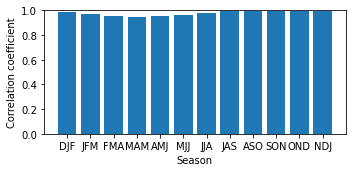

In [41]:
from ninolearn.plot.evaluation import plot_correlation

loss = model.evaluate(testy, pred_mean, pred_std)
print(f"Loss (Negative-Log-Likelihood): {loss}")

# make a plot of the seasonal correaltion
# note: - pd.tseries.offsets.MonthBegin(1) appears to ensure that the correlations are plotted
# agains the correct season
plot_correlation(testy, pred_mean, testtimey - pd.tseries.offsets.MonthBegin(1), title="")